#Importing all the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as gph
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.feature_selection import RFE
import pickle

In [ ]:
np.random.seed(42)

data_path = "/content/diabetes.csv"
diabete = pd.read_csv(data_path)

In [ ]:
print(diabete.head())

print("\n Structure of the data:", diabete.shape)
print("\n diabetes Dataset info:")
print(diabete.info())
print("\n Summary statistics of diabetes:")
print(diabete.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

 Structure of the data: (768, 9)

 diabetes Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies              

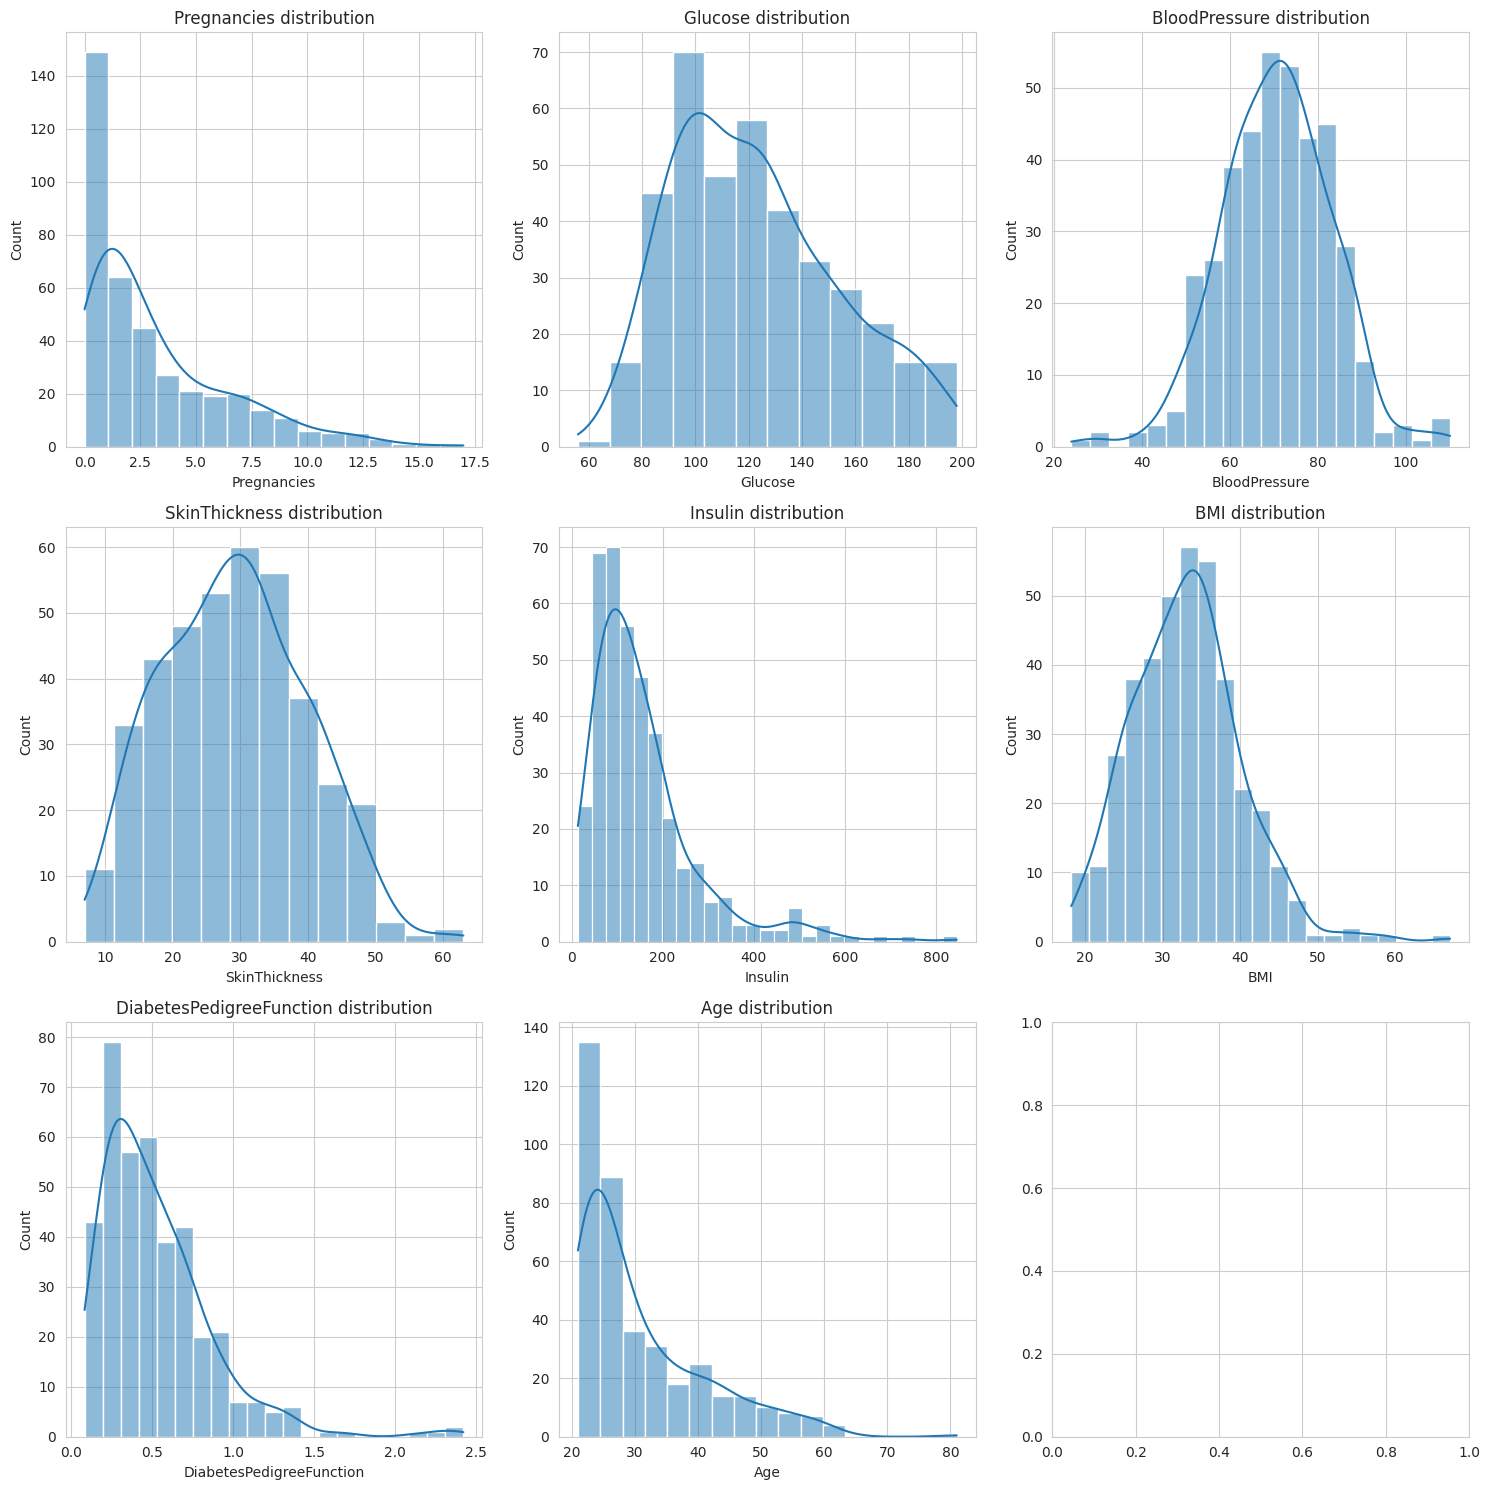

In [ ]:
sns.set_style("whitegrid")
fig, ax = gph.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, col in enumerate(diabete.columns[:-1]):
    sns.histplot(dataset[col], ax=ax[i // 3, i % 3], kde=True)
    ax[i // 3, i % 3].set_title(f"{col} distribution")

gph.tight_layout()
gph.show()

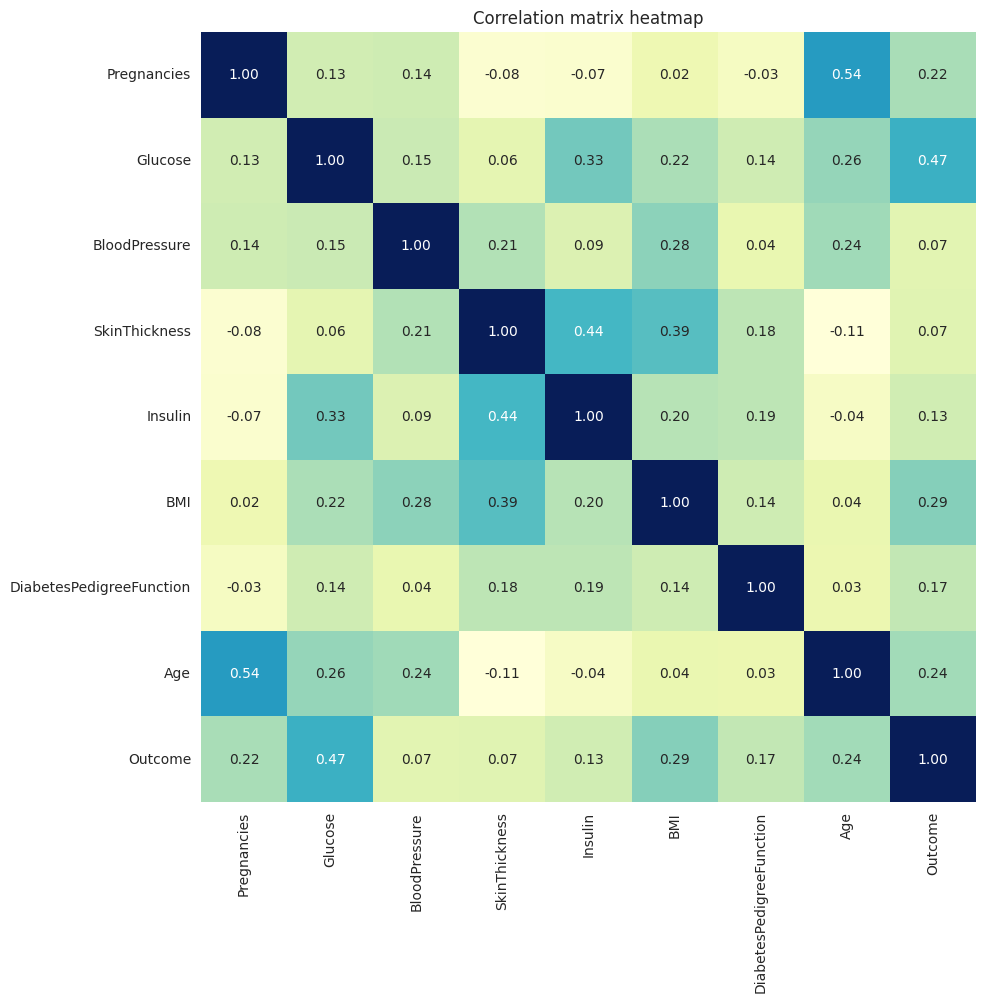

In [ ]:
gph.figure(figsize=(10, 10))
sns.heatmap(diabete.corr(), annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
gph.title("Correlation matrix heatmap")
gph.show()

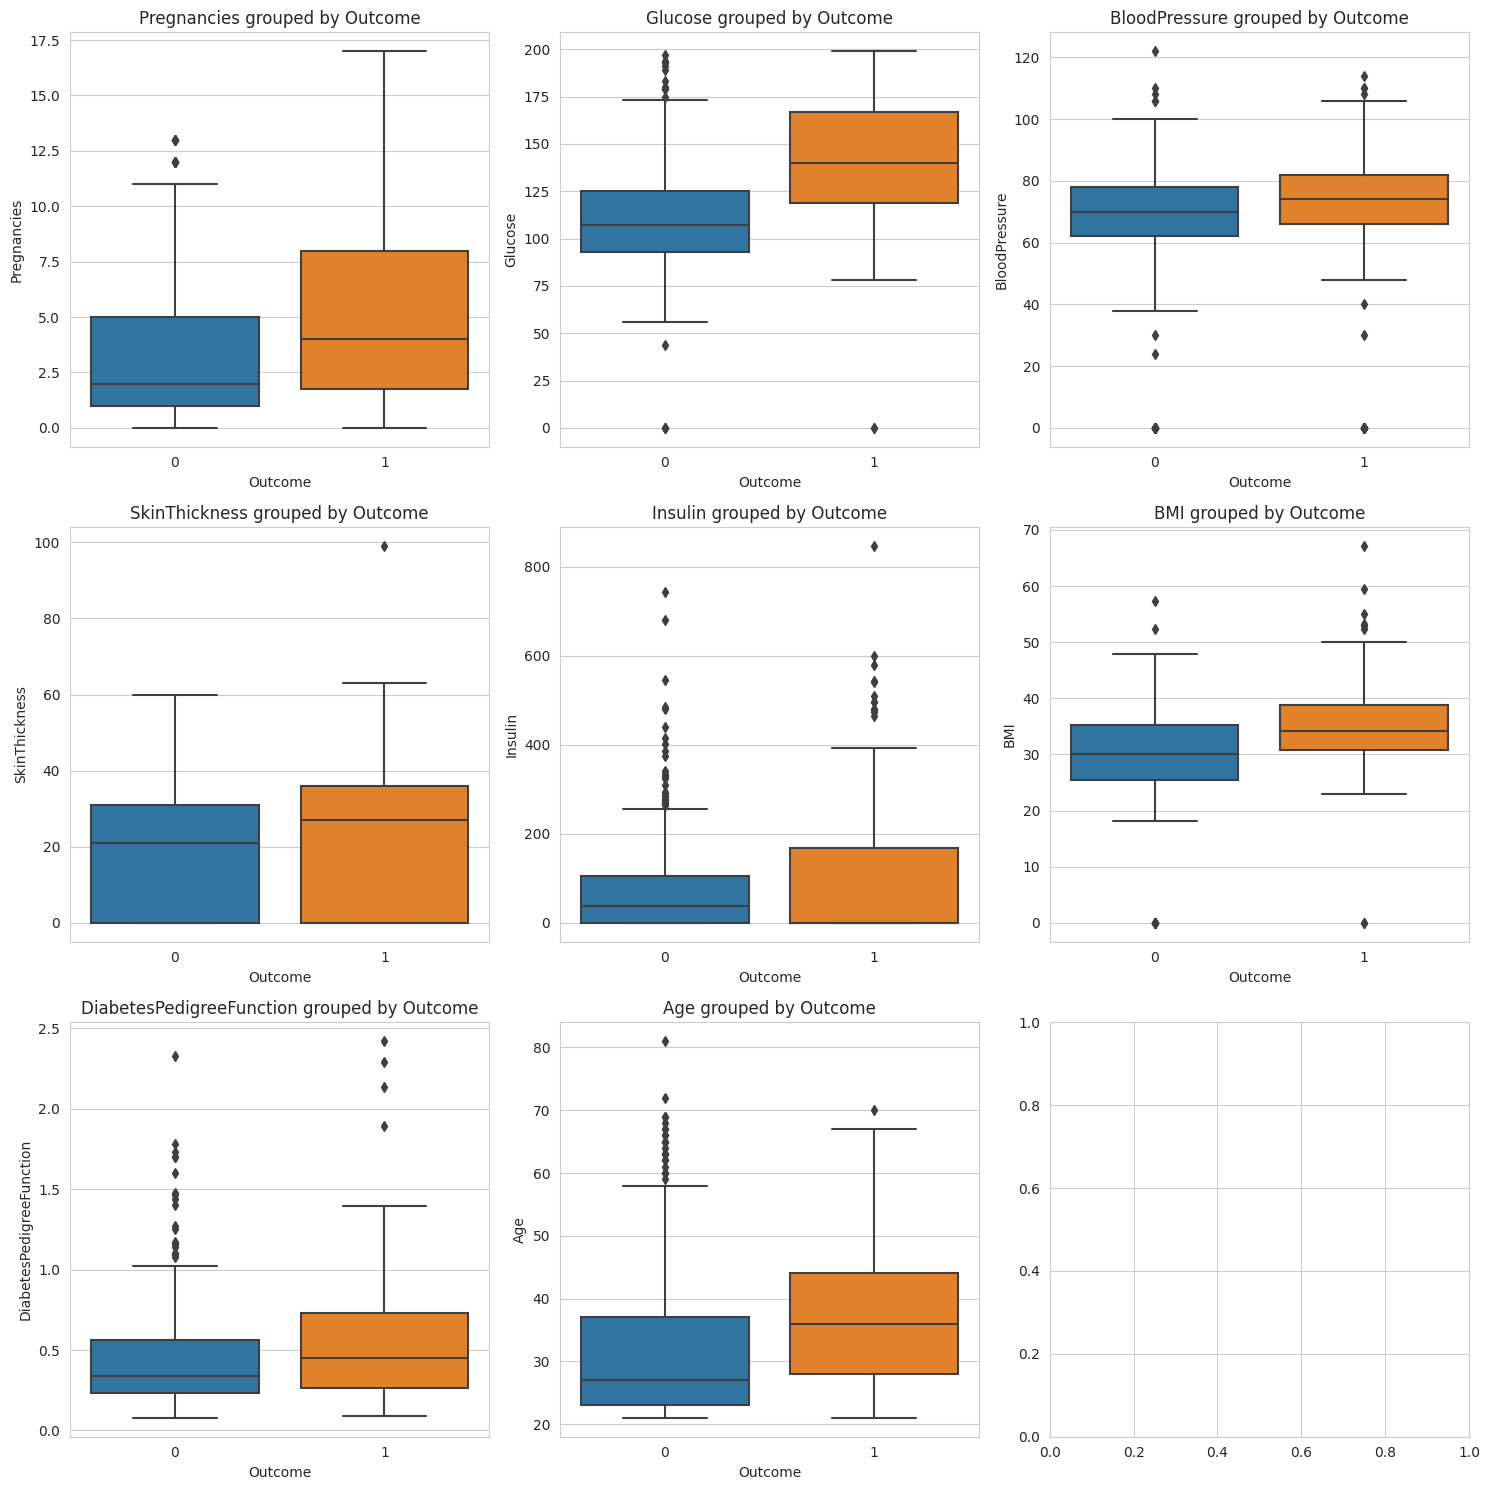

In [ ]:
fig, ax = gph.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, col in enumerate(dataset.columns[:-1]):
    sns.boxplot(x="Outcome", y=col, data=diabete, ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(f"{col} grouped by Outcome")

gph.tight_layout()
gph.show()



In [ ]:
cols_to_replace = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
dataset[cols_to_replace] = diabete[cols_to_replace].replace(0, float("nan"))

diabete = diabete.dropna()

In [ ]:
X = diabete.drop("Outcome", axis=1)
y = diabete["Outcome"]

X_Training, X_Testing, Y_Training, Y_Testing = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_Training = scaler.fit_transform(X_Training)
X_Testing = scaler.transform(X_Testing)


In [ ]:
model_list = [
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector Machines", SVC(probability=True)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Trees", DecisionTreeClassifier()),
    ("Random Forests", RandomForestClassifier()),
    ("Naïve Bayes", GaussianNB()),
    ("Neural Networks", MLPClassifier())
]

evaluation_metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"]


In [ ]:
for model_name, model_obj in model_list:
    scores = cross_validate(model_obj, X_Training, Y_Training, cv=5, scoring=evaluation_metrics)
    print(model_name)
    print(f" Accrcy: {scores['test_accuracy'].mean():.3f}")
    print(f" Prcsion: {scores['test_precision_macro'].mean():.3f}")
    print(f" Recl: {scores['test_recall_macro'].mean():.3f}")
print(f" F1-score: {scores['test_f1_macro'].mean():.3f}")
print(f" AUC-ROC: {scores['test_roc_auc'].mean():.3f}")
print("=" * 30)

dt_params = {
"criterion": ["gini", "entropy"],
"max_depth": [2, 4, 6, 8, 10],
"min_samples_split": [2, 5, 10],
"min_samples_leaf": [1, 2, 4],
}

dt_model = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt_model, param_grid=dt_params, cv=5)
dt_cv.fit(X_Training, Y_Training)
optimal_dt = dt_cv.best_estimator_
print(f" Best parameters for Decision Trees: {dt_cv.best_params_}")
print(f" Accurcy: {dt_cv.best_score_:.3f}")
print("=" * 30)

rf_params = {
"n_estimators": [100, 200, 300],
"criterion": ["gini", "entropy"],
"max_depth": [2, 4, 6, 8, 10],
"min_samples_split": [2, 5, 10],
"min_samples_leaf": [1, 2, 4],
}

rf_model = RandomForestClassifier()
rf_cv = GridSearchCV(rf_model, param_grid=rf_params, cv=5)
rf_cv.fit(X_Training, Y_Training)
optimal_rf = rf_cv.best_estimator_

print(f"Best parameters for Random Forests: {rf_cv.best_params_}")
print(f"Accuracy: {rf_cv.best_score_:.3f}")
print("=" * 30)

rfc = RandomForestClassifier(max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=100)

rfe_selector = RFE(estimator=rfc, n_features_to_select=5)
rfe_selector.fit(X_Training, Y_Training)
selected_features = X.columns[rfe_selector.support_]
print(f"Selected features using RFE: {selected_features}")

X_train_rfe = rfe_selector.transform(X_Training)
X_test_rfe = rfe_selector.transform(X_Testing)

models_rfe = [
("Logistic Regression", LogisticRegression()),
("Support Vector Machines", SVC(C=0.1, kernel="linear", gamma="scale")),
("K-Nearest Neighbors", KNeighborsClassifier()),
("Decision Trees", DecisionTreeClassifier()),
("Random Forests", RandomForestClassifier(max_depth=6, min_samples_leaf=1, min_samples_split=10, n_estimators=100)),
("Naïve Bayes", GaussianNB()),
("Neural Networks", MLPClassifier())
]

for model_name, model_obj in models_rfe:
  scores = cross_validate(model_obj, X_train_rfe, Y_Training, cv=5, scoring=evaluation_metrics)
  print(f"{ model_name} with selected features")
  print(f" Accuracy: {scores['test_accuracy'].mean():.3f}")
  print(f" Precision: {scores['test_precision_macro'].mean():.3f}")
  print(f" Recall: {scores['test_recall_macro'].mean():.3f}")
  print(f" F1-score: {scores['test_f1_macro'].mean():.3f}")
  print(f" AUC-ROC: {scores['test_roc_auc'].mean():.3f}")
  print("=" * 30)

Logistic Regression
 Accrcy: 0.761
 Prcsion: 0.741
 Recl: 0.711
Support Vector Machines
 Accrcy: 0.769
 Prcsion: 0.751
 Recl: 0.722
K-Nearest Neighbors
 Accrcy: 0.744
 Prcsion: 0.720
 Recl: 0.706
Decision Trees
 Accrcy: 0.725
 Prcsion: 0.698
 Recl: 0.698
Random Forests
 Accrcy: 0.766
 Prcsion: 0.744
 Recl: 0.726
Naïve Bayes
 Accrcy: 0.752
 Prcsion: 0.730
 Recl: 0.713


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Neural Networks
 Accrcy: 0.759
 Prcsion: 0.735
 Recl: 0.723
 F1-score: 0.727
 AUC-ROC: 0.835
 Best parameters for Decision Trees: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
 Accurcy: 0.761
Best parameters for Random Forests: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.790
Selected features using RFE: Index(['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')
Logistic Regression with selected features
 Accuracy: 0.767
 Precision: 0.750
 Recall: 0.721
 F1-score: 0.729
 AUC-ROC: 0.830
Support Vector Machines with selected features
 Accuracy: 0.772
 Precision: 0.758
 Recall: 0.722
 F1-score: 0.733
 AUC-ROC: 0.832
K-Nearest Neighbors with selected features
 Accuracy: 0.744
 Precision: 0.720
 Recall: 0.704
 F1-score: 0.709
 AUC-ROC: 0.791
Decision Trees with selected features
 Accuracy: 0.702
 Precision: 0.674
 Recall: 0.675
 F1-score: 0.673
 AUC-RO

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Networks with selected features
 Accuracy: 0.759
 Precision: 0.735
 Recall: 0.721
 F1-score: 0.726
 AUC-ROC: 0.839


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
model_filename = 'finalized_model.sav'
pickle.dump(optimal_rf, open(model_filename, 'wb'))

loaded_model = pickle.load(open(model_filename, 'rb'))
y_pred = loaded_model.predict(X_Testing)
test_accuracy = (y_pred == Y_Testing).sum() / len(Y_Testing)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy on test set: 0.753


In [ ]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Support Vector Machines", SVC(probability=True)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Trees", DecisionTreeClassifier()),
    ("Random Forests", RandomForestClassifier()),
    ("Naïve Bayes", GaussianNB()),
    ("Neural Networks", MLPClassifier())
]


In [ ]:
accuracy_results = {}
for model_name, model_obj in models:
  scores = cross_validate(model_obj, X_Training, Y_Training, cv=5, scoring=["accuracy"])
  accuracy_results[model_name] = scores["test_accuracy"].mean()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

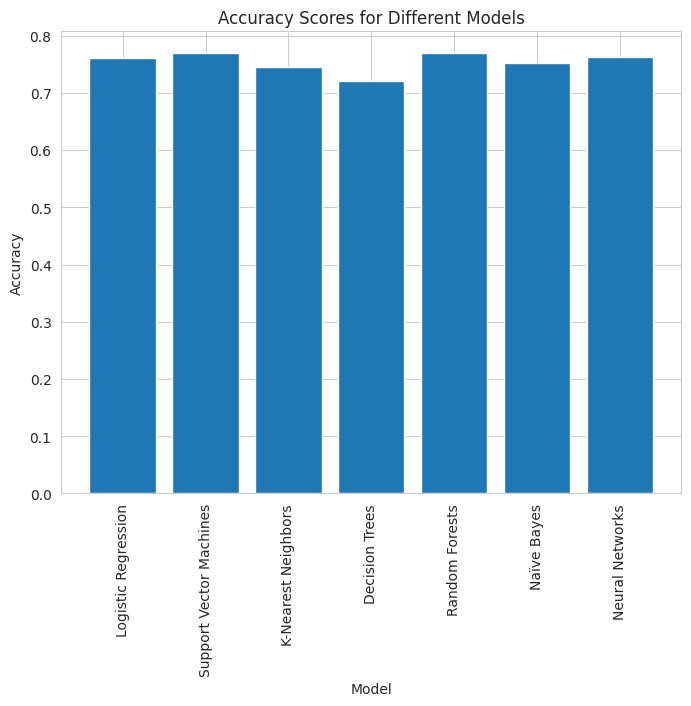

In [ ]:
sns.set_style("whitegrid")
gph.figure(figsize=(8, 6))
gph.bar(range(len(accuracy_results)), list(accuracy_results.values()), align="center")
gph.xticks(range(len(accuracy_results)), list(accuracy_results.keys()), rotation=90)
gph.xlabel("Model")
gph.ylabel("Accuracy")
gph.title("Accuracy Scores for Different Models")
gph.show()

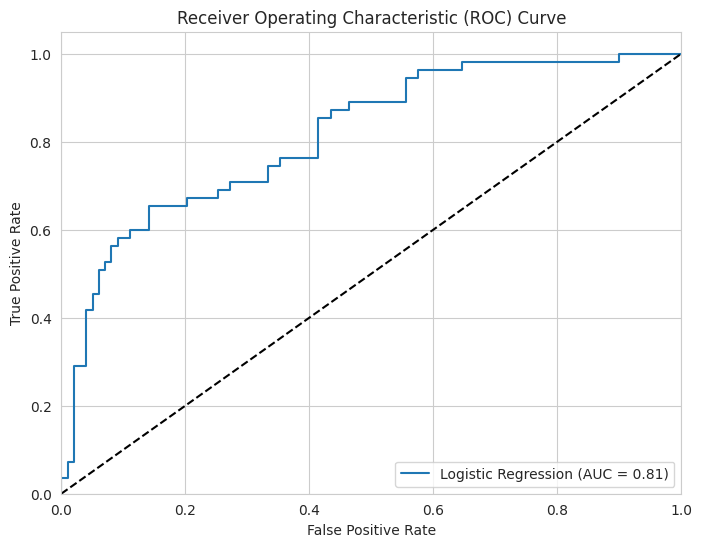

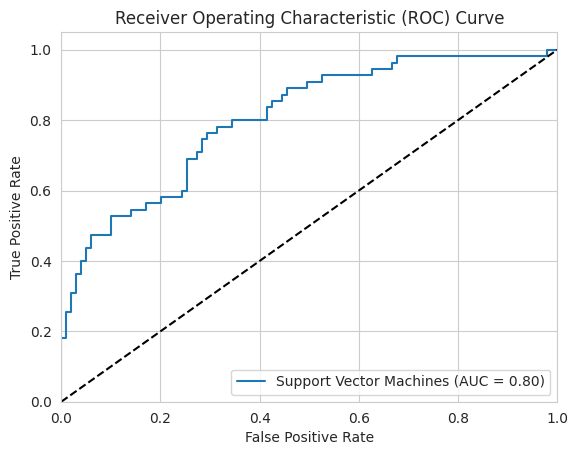

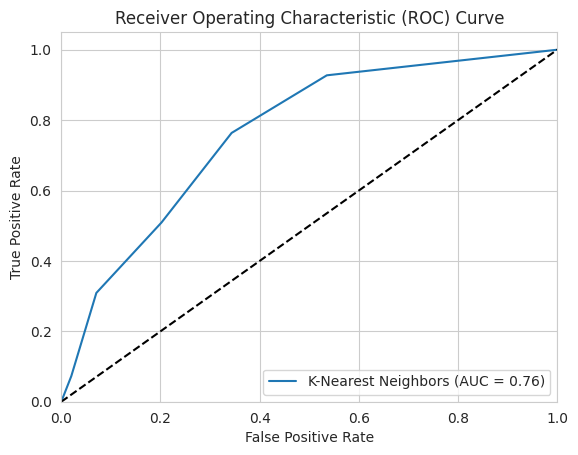

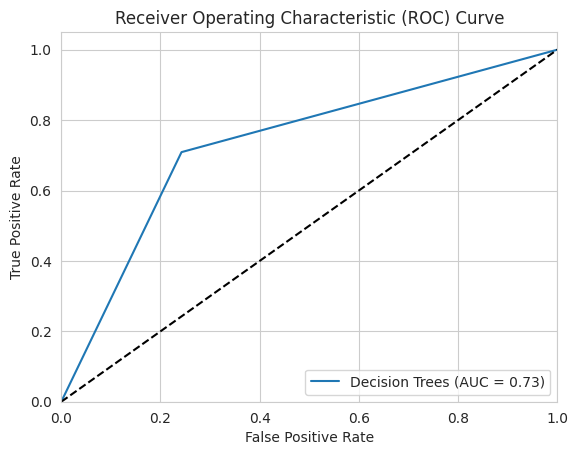

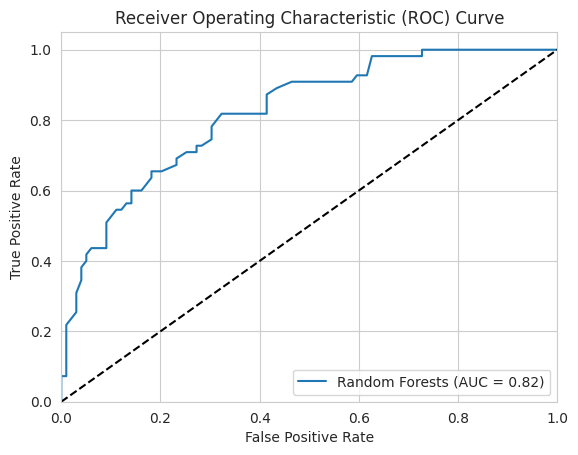

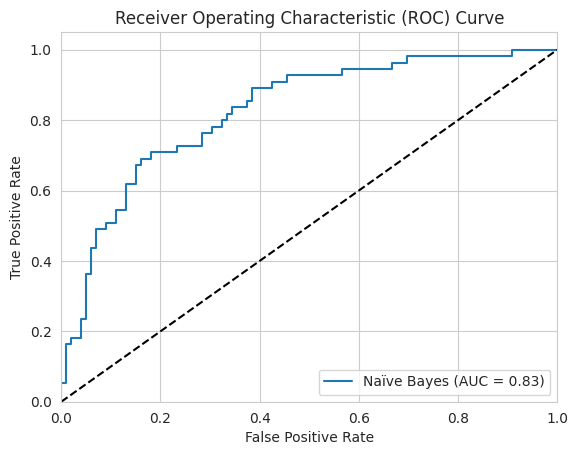

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


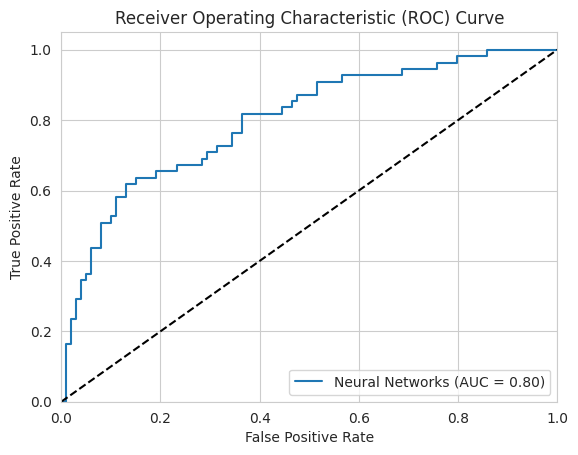

In [ ]:
def plot_roc(models, X_Testing, Y_Testing):
  gph.figure(figsize=(8, 6))
  for name, model in models:
    model.fit(X_Training, Y_Training)
    y_pred_proba = model.predict_proba(X_Testing)[:, 1]
    fpr, tpr, _ = roc_curve(Y_Testing, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    gph.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    gph.plot([0, 1], [0, 1], 'k--')
    gph.xlim([0.0, 1.0])
    gph.ylim([0.0, 1.05])
    gph.xlabel("False Positive Rate")
    gph.ylabel("True Positive Rate")
    gph.title("Receiver Operating Characteristic (ROC) Curve")
    gph.legend(loc="lower right")
    gph.show()


plot_roc(models, X_Testing, Y_Testing)

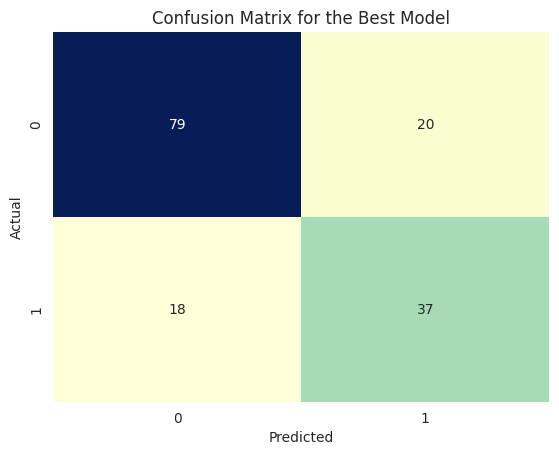

In [ ]:
def plot_cm(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
  gph.xlabel("Predicted")
  gph.ylabel("Actual")
  gph.title(title)
  gph.show()

plot_cm(Y_Testing, y_pred, "Confusion Matrix for the Best Model")

In [ ]:
evaluation_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"])

for model_name, model_obj in models:
  scores = cross_validate(model_obj, X_Training, Y_Training, cv=5, scoring=evaluation_metrics)
  evaluation_df = evaluation_df.append({
  "Model": model_name,
  "Accuracy": scores['test_accuracy'].mean(),
  "Precision": scores['test_precision_macro'].mean(),
  "Recall": scores['test_recall_macro'].mean(),
  "F1-score": scores['test_f1_macro'].mean(),
  "AUC-ROC": scores['test_roc_auc'].mean()
  }, ignore_index=True)

print(evaluation_df)

<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append({
<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append({
<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append({
<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append({
<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

                     Model  Accuracy  Precision    Recall  F1-score   AUC-ROC
0      Logistic Regression  0.760629   0.741359  0.711328  0.719978  0.831526
1  Support Vector Machines  0.768746   0.750623  0.721920  0.730140  0.833487
2      K-Nearest Neighbors  0.744356   0.719964  0.705540  0.709761  0.786720
3           Decision Trees  0.723057   0.695152  0.694612  0.693862  0.694612
4           Random Forests  0.768733   0.748768  0.727353  0.734573  0.829374
5              Naïve Bayes  0.752472   0.729645  0.712653  0.718234  0.806226
6          Neural Networks  0.760589   0.736728  0.723270  0.727860  0.832489


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
<ipython-input-45-df8a4c3aa810>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append({
